## Introduction

This Jupyter Notebook demonstrates an unsupervised learning approach to classify audio data. The methodology encompasses several stages: feature extraction from audio signals, feature normalization and transformation, autoencoder-based dimensionality reduction, clustering of compressed features, and visual interpretation of the clusters using t-SNE. The autoencoder learns to compress the feature space and K-means clustering is then applied to the compressed representation, with t-SNE providing a visual understanding of the learned clusters.

In [1]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Feature Extraction

Here, we define a function to load audio data and extract various descriptive features.
Feature extraction is crucial as raw audio signals cannot be directly used for analysis.
We extract the following features:
- Mel-Frequency Cepstral Coefficients (MFCCs): Capture the power spectrum of audio.
- Chroma Frequencies: Represent the twelve different pitch classes.
- Mel-Spectrogram: Highlight the frequency content of the audio with respect to time.
- Spectral Contrast: Consider the difference in amplitude between peaks and troughs in the spectrum.
- Tonnetz: Estimate tonal centroids, representing harmonic relations.
These features are combined into a single feature vector to provide a comprehensive analysis of the audio data.

In [2]:
def load_and_extract_features(file_path, sr=22050):
    y, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.concatenate([mfcc, chroma, mel, contrast, tonnetz])
    return features.T

### Building the Convolutional Autoencoder Model

This function is responsible for constructing the autoencoder, a type of neural network.
The autoencoder architecture consists of two main parts: the encoder and the decoder.
- Encoder: Reduces the dimensionality of the input, creating a compressed representation.
- Decoder: Reconstructs the input data from this compressed representation as closely as possible to the original input.
The autoencoder is trained using backpropagation, aiming to reduce the reconstruction error, thus learning the most important features of the data.

In [3]:
def build_conv_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv1D(32, 3, activation="relu", padding="same")(input_layer)
    x = MaxPooling1D(2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv1D(16, 3, activation="relu", padding="same")(x)
    x = MaxPooling1D(2, padding="same")(x)
    encoded = BatchNormalization()(x)

    x = Conv1D(16, 3, activation="relu", padding="same")(encoded)
    x = UpSampling1D(2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(32, 3, activation="relu", padding="same")(x)
    x = UpSampling1D(2)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(np.prod(input_shape), activation='relu')(x)
    decoded = Reshape(input_shape)(x)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return autoencoder, encoder

### Training the Model and Feature Compression

The encoded (compressed) features from the autoencoder are used for clustering.
The KMeans algorithm groups the data into clusters, with the number of clusters predefined.
KMeans optimization aims to minimize the within-cluster variance, thus improving the homogeneity of clusters.
Clustering high-dimensional data can be challenging; hence, using the compressed features makes this process more effective and interpretable.


In [4]:
audio_file_path = "C:\\Users\\22396\Downloads\\test.wav"

features = load_and_extract_features(audio_file_path)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled_reshaped = features_scaled.reshape(-1, features_scaled.shape[1], 1)

input_shape = (features_scaled.shape[1], 1)
autoencoder, encoder = build_conv_autoencoder(input_shape)

autoencoder.fit(features_scaled_reshaped,
                features_scaled_reshaped,
                epochs=50, batch_size=128)

compressed_features = encoder.predict(features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1))
compressed_features_flattened = compressed_features.reshape(compressed_features.shape[0], -1)

Epoch 1/50
4/4 [==============================] - 2s 31ms/step - loss: 1.2576
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 0.7621
Epoch 3/50
4/4 [==============================] - 0s 11ms/step - loss: 0.6941
Epoch 4/50
4/4 [==============================] - 0s 12ms/step - loss: 0.6467
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6187
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6036
Epoch 7/50
4/4 [==============================] - 0s 12ms/step - loss: 0.5905
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 0.5875
Epoch 9/50
4/4 [==============================] - 0s 11ms/step - loss: 0.5757
Epoch 10/50
4/4 [==============================] - 0s 11ms/step - loss: 0.5804
Epoch 11/50
4/4 [==============================] - 0s 12ms/step - loss: 0.5707
Epoch 12/50
4/4 [==============================] - 0s 9ms/step - loss: 0.5677
Epoch 13/50
4/4 [==============================] - 0s 10ms/step 

### Clustering Compressed Features

The encoded (compressed) features from the autoencoder are used for clustering.
The KMeans algorithm groups the data into clusters, with the number of clusters predefined.
KMeans optimization aims to minimize the within-cluster variance, thus improving the homogeneity of clusters.
Clustering high-dimensional data can be challenging; hence, using the compressed features makes this process more effective and interpretable.


In [5]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(compressed_features_flattened)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(compressed_features_flattened)

C:\Users\22396\anaconda3\envs\EngineDemo\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Visualizing the Feature Clusters

We employ t-SNE, a tool to visualize high-dimensional data in a two or three-dimensional space.
t-SNE reduces dimensionality while attempting to preserve the relative distances between data points, making it a powerful tool for visualization.
The scatter plot created by t-SNE provides a bird’s-eye view of the clusters and their distribution, assisting in identifying patterns or groups within the data.


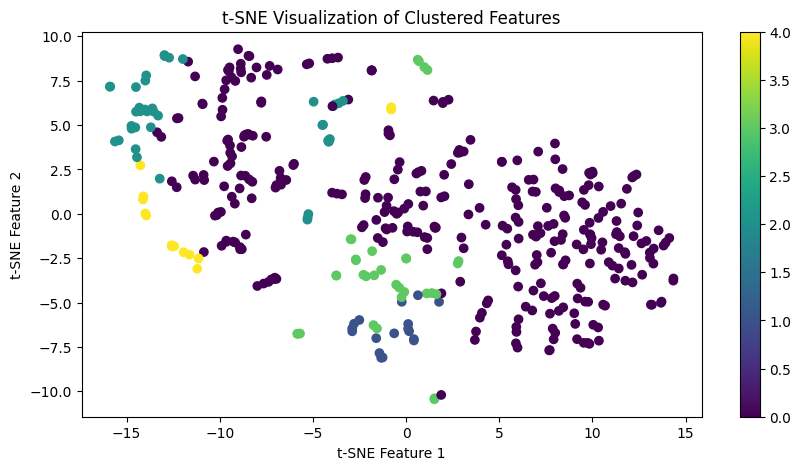

In [6]:
plt.figure(figsize=(10, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("t-SNE Visualization of Clustered Features")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.colorbar()
plt.show()